<a href="https://colab.research.google.com/github/mamtakumari-hub/Predict-Candidate-Fit-Score/blob/main/Predict_Candidate_Fit_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Upload Both  Files**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install pandas numpy scikit-learn nltk joblib


**Step 2: Load Datasets**

In [24]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import sklearn
import joblib



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
candidates=pd.read_csv('/content/candidate_job_role_dataset.csv')
jobs=pd.read_csv('/content/naukri_data_science_jobs_india.csv')

candidates.head()
jobs.head()
print(candidates.shape, jobs.shape)


(1000, 5) (12000, 5)


In [26]:
candidates.info()
candidates.describe()
jobs.info()
jobs.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   candidate_id      1000 non-null   int64 
 1   skills            1000 non-null   object
 2   qualification     1000 non-null   object
 3   experience_level  1000 non-null   object
 4   job_role          1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job_Role            12000 non-null  object
 1   Company             12000 non-null  object
 2   Location            12000 non-null  object
 3   Job Experience      12000 non-null  object
 4   Skills/Description  12000 non-null  object
dtypes: object(5)
memory usage: 468.9+ KB


,Job_Role,Company,Location,Job Experience,Skills/Description
count,12000,12000,12000,12000,12000
unique,6563,3507,822,143,11356
top,Data Engineer,Accenture,Bangalore/Bengaluru,5-10,Data Scientist
freq,580,490,3383,944,8


**STEP 3: Data Processing & Cleaning**

In [27]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z ]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)


**STEP 4: Feature Engineering**

In [28]:
candidates["cand_text"] = (
    candidates["skills"].fillna('') + " " +
    candidates["qualification"].fillna('') + " " +
    candidates["experience_level"].fillna('') + " " +
    candidates["job_role"].fillna('')
)

candidates["cand_text"] = candidates["cand_text"].apply(clean_text)


In [29]:
jobs["job_text"] = (
    jobs["Job_Role"].fillna('') + " " +
    jobs["Skills/Description"].fillna('')
)

jobs["job_text"] = jobs["job_text"].apply(clean_text)


**STEP 5: Create Training Pairs & Labels**

In [30]:

pairs = []

for _, c in candidates.iterrows():
    for _, j in jobs.sample(min(5, len(jobs))).iterrows():
        text = c["cand_text"] + " " + j["job_text"]
        label = 1 if c["job_role"].lower() in j["Job_Role"].lower() else 0
        pairs.append([text, label])

pairs_df = pd.DataFrame(pairs, columns=["text", "label"])
pairs_df.head()


,text,label
0,python sql tensorflow machine learning communi...,0
1,python sql tensorflow machine learning communi...,1
2,python sql tensorflow machine learning communi...,1
3,python sql tensorflow machine learning communi...,0
4,python sql tensorflow machine learning communi...,0


**STEP 6: Train–Test Split:**

In [31]:
X = pairs_df["text"]
y = pairs_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**STEP 7: Model Development (Train)**


TF-IDF + Logistic Regression

In [32]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])





**STEP 8: Train Model**

In [33]:
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))])

**STEP 9: Evaluation**

In [34]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.987

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       987
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1000
   macro avg       0.49      0.50      0.50      1000
weighted avg       0.97      0.99      0.98      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**STEP 10: Prediction Function**

In [35]:
def predict_fit(candidate_row, job_row, model):
    text = clean_text(
        candidate_row["skills"] + " " +
        candidate_row["qualification"] + " " +
        candidate_row["experience_level"] + " " +
        candidate_row["job_role"] + " " +
        job_row["Job_Role"] + " " +
        job_row["Skills/Description"]
    )
    prob = model.predict_proba([text])[0][1]
    return round(prob * 100, 2)



**STEP 11: Explanation: Key Matching Factors**

In [36]:
def explain_match(candidate_row, job_row, top_n=6):
    cand_words = set(clean_text(candidate_row["skills"]).split())
    job_words = set(clean_text(job_row["Skills/Description"]).split())
    return list(cand_words.intersection(job_words))[:top_n]


In [37]:
c = candidates.iloc[0]
j = jobs.iloc[0]

score = predict_fit(c, j, model)
keywords = explain_match(c, j)

print("Fit Score:", score, "%")
print("Key Matching Factors:", keywords)


Fit Score: 8.28 %
Key Matching Factors: ['python', 'machine', 'learning']


In [38]:
pairs_df["label"].value_counts(normalize=True)


,proportion
label,
0,0.9872
1,0.0128


In [39]:
pos = pairs_df[pairs_df["label"] == 1]
neg = pairs_df[pairs_df["label"] == 0].sample(len(pos), random_state=42)

pairs_balanced = pd.concat([pos, neg]).sample(frac=1, random_state=42)
print(pairs_balanced["label"].value_counts())


label
1    64
0    64
Name: count, dtype: int64


In [40]:
def create_label(c, j):
    cand_skills = set(clean_text(c["skills"]).split())
    job_skills = set(clean_text(j["Skills/Description"]).split())
    overlap = len(cand_skills.intersection(job_skills))

    role_match = c["job_role"].lower() in j["Job_Role"].lower()

    return 1 if (role_match or overlap >= 3) else 0


In [41]:
label = create_label(c, j)


In [42]:
X = pairs_balanced["text"]
y = pairs_balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [43]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.85      0.92        13

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26



In [44]:
score = predict_fit(c, j, model)
keywords = explain_match(c, j)

print("Fit Score:", score, "%")
print("Key Matching Factors:", keywords)


Fit Score: 73.43 %
Key Matching Factors: ['python', 'machine', 'learning']


Download

In [52]:

from sklearn.metrics import precision_recall_fscore_support


precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)


df_metrics = pd.DataFrame({
    "class": [0, 1],
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "support": support
})

df_metrics.loc["accuracy"] = [ "accuracy", acc, "", "", len(y_test) ]

df_metrics.to_csv("model_metrics.csv", index=False)


# files.download("model_metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
new_candidate = {
    "skills": "Python, Machine Learning, Deep Learning, SQL",
    "qualification": "Master's in Data Science",
    "experience_level": "Senior",
    "job_role": "Data Scientist"
}

new_job = {
    "Job_Role": "Senior Data Scientist",
    "Skills/Description": "Looking for expert in Python, ML, statistics, data analysis and deep learning"
}


In [46]:
score = predict_fit(pd.Series(new_candidate), pd.Series(new_job), model)
keywords = explain_match(pd.Series(new_candidate), pd.Series(new_job))

print("Fit Score:", score, "%")
print("Key Matching Factors:", keywords)


Fit Score: 70.14 %
Key Matching Factors: ['python', 'deep', 'learning']


In [47]:
import matplotlib.pyplot as plt

job = jobs.iloc[0]

scores = []
names = []

for idx, c in candidates.iterrows():
    s = predict_fit(c, job, model)
    scores.append(s)
    names.append(f"Cand_{idx+1}")


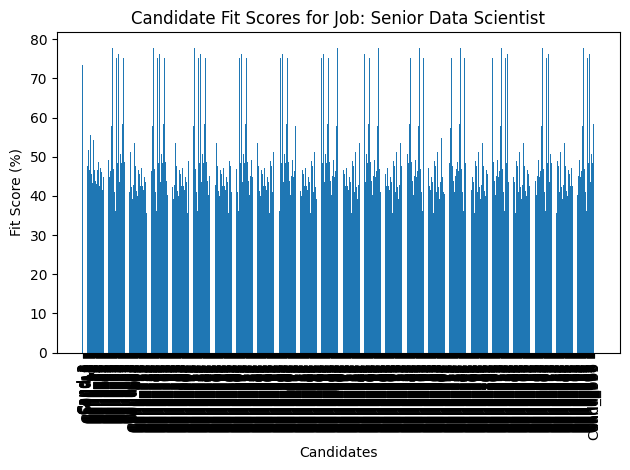

In [48]:
plt.figure()
plt.bar(names, scores)
plt.xlabel("Candidates")
plt.ylabel("Fit Score (%)")
plt.title("Candidate Fit Scores for Job: " + job["Job_Role"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [49]:
shortlisted = [(n, s) for n, s in zip(names, scores) if s >= 70]
shortlisted


[('Cand_1', np.float64(73.43)),
 ('Cand_19', np.float64(75.37)),
 ('Cand_27', np.float64(75.53)),
 ('Cand_31', np.float64(75.18)),
 ('Cand_41', np.float64(75.13)),
 ('Cand_59', np.float64(77.86)),
 ('Cand_67', np.float64(75.08)),
 ('Cand_71', np.float64(76.22)),
 ('Cand_81', np.float64(75.13)),
 ('Cand_99', np.float64(77.86)),
 ('Cand_107', np.float64(75.08)),
 ('Cand_111', np.float64(76.22)),
 ('Cand_121', np.float64(75.13)),
 ('Cand_139', np.float64(77.86)),
 ('Cand_147', np.float64(75.08)),
 ('Cand_151', np.float64(76.22)),
 ('Cand_161', np.float64(75.13)),
 ('Cand_179', np.float64(77.86)),
 ('Cand_187', np.float64(75.08)),
 ('Cand_191', np.float64(76.22)),
 ('Cand_201', np.float64(75.13)),
 ('Cand_219', np.float64(77.86)),
 ('Cand_227', np.float64(75.08)),
 ('Cand_231', np.float64(76.22)),
 ('Cand_241', np.float64(75.13)),
 ('Cand_259', np.float64(77.86)),
 ('Cand_267', np.float64(75.08)),
 ('Cand_271', np.float64(76.22)),
 ('Cand_281', np.float64(75.13)),
 ('Cand_299', np.float64(

In [50]:
import joblib
joblib.dump(model, "job_candidate_matcher.pkl")


['job_candidate_matcher.pkl']

In [51]:
from google.colab import files

files.download("job_candidate_matcher.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
readme_text="""
# Predict Candidate Fit Score

## 📌 Overview
This project predicts how well a candidate matches a job description
using NLP and supervised machine learning.

## 🎯 Objective To build a Python-based machine learning solution that
compares candidate profiles with job descriptions and generates a
fit score with explanations.

## Tech Stack
- Python
- Pandas
- NumPy
- scikit-learn
- NLTK

## Datasets
candidates.csv:
- candidate_id
- skills
- qualification
- experience_level
- job_role

jobs.csv:
- Job_Role
- Company
- Location
- Job Experience
- Skills/Description

## Approach
1. Clean and preprocess text data
2. Combine candidate and job features
3. Create candidate–job pairs with labels
4. Balance classes
5. Extract features using TF-IDF
6. Train Logistic Regression classifier
7. Evaluate using accuracy and classification report
8. Predict fit score (0–100%) with keyword explanation

## Model
TF-IDF + Logistic Regression (scikit-learn Pipeline)

## How to Run
1. Open the notebook in Google Colab
2. Upload candidates.csv and jobs.csv
3. Run all cells from top to bottom
4. The trained model is saved as:
   job_candidate_matcher.pkl
5. Download model_metrics.csv

## Output
- Accuracy and performance metrics
- Fit score for candidate–job pair
- Key matching skills
- Saved trained model

## Example
Fit Score:73.43%
Key Matching Factors: ['python', 'machine', 'learning']

## 👩‍💻 Author
Mamta Kumari
"""
with open("README.md", "w") as f:
   f.write(readme_text)
   f.close()
   print("README.md created!")


README.md created!
